## **1. Data Preparation**

In [1]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
# from xgboost import XGBRegressor

from src import data_preprocessing as dp
from src import pipeline as pl
from src import new_feature_engineering_daily as fe
from src import feature_selection as fs
from src.model_evaluation import evaluate, evaluate_multi_output
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


d:\code\Python\DSEB_ex\ML1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")

# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 4. Fit preprocessing pipeline trên train
pipeline1 = pl.build_preprocessing_pipeline()
pipeline1.fit(train_df)

# 5. Transform cả train và test
train_processed = pipeline1.transform(train_df)
test_processed = pipeline1.transform(test_df)

# 6. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 7. Fit preprocessing pipeline trên train
pipeline1 = pl.build_preprocessing_pipeline()
pipeline1.fit(train_df)

# 8. Transform cả train và test
train_processed = pipeline1.transform(train_df)
test_processed = pipeline1.transform(test_df)

# 9. Lưu lại pipeline 1
# joblib.dump(pipeline1, r"pipelines\preprocessing_pipeline.pkl")

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'


In [3]:
# 1. Không sử dụng các biến interaction: is_linear = False

# Tạo feature engineering (drop NaN sau khi rolling/lag)
train_feat, target_col = fe.feature_engineering(train_processed, is_drop_nan= True, is_linear= False) # không tạo biến interaction
test_feat, _ = fe.feature_engineering(test_processed, is_drop_nan= True, is_linear= False)

# Chia X, y riêng biệt
X_train = train_feat.drop(columns= target_col)
y_train = train_feat[target_col]

X_test = test_feat.drop(columns= target_col)
y_test = test_feat[target_col]

# 2. Drop base - Chỉ sử dụng derive feature
print('\nDrop Base')
print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
X_train = fe.drop_base_features(X_train)
X_test = fe.drop_base_features(X_test)
print('số lượng sau drop base', X_train.shape, X_test.shape)


Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.

Drop Base
số lượng Trước Khi drop base (2893, 256) (697, 256)
số lượng sau drop base (2893, 235) (697, 235)


In [4]:
# 3. Kiểm tra các biến Category
encoder = pl.build_encoding_pipeline(is_category=True)
encoder.fit(X_train, train_feat['temp'])

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# Kích thước dữ liệu
print("=" * 60)
print(f" Kích thước dữ liệu:")
print(f"   - Train: {X_train.shape} | Target: {y_train.shape}")
print(f"   - Test : {X_test.shape} | Target: {y_test.shape}")

print("=" * 60)
cat_features = X_train.select_dtypes(include=['category']).columns

print("\nThông tin chi tiết các feature categorical:")
for col in cat_features:
    unique_vals = list(X_train[col].unique())
    print(f"• {col} ({len(unique_vals)} lớp): {unique_vals}")


 Kích thước dữ liệu:
   - Train: (2893, 236) | Target: (2893, 5)
   - Test : (697, 236) | Target: (697, 5)

Thông tin chi tiết các feature categorical:
• conditions (6 lớp): ['Clear', 'Rain', 'Rain, Partially cloudy', 'Partially cloudy', 'Rain, Overcast', 'Overcast']
• wind_category (8 lớp): ['Đông_Bắc_NE', 'Đông_Nam_SE', 'Bắc_N', 'Nam_S', 'Bắc_Đông Bắc_N_NE', 'Tây_Bắc_NW', 'Tây_Nam_SW', 'Tây_W']
• season (5 lớp): [2, 1, 0, 3, 4]


## **2. Model Training**

In [ ]:
# Đổi tên task trong task_name
if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="LGB Optuna Tuning 7: sửa lại một tý + rerun để lấy output",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

ClearML Task: created new task id=3188202484a54fa89e67972ecf9b0fa1
2025-11-10 17:35:35,521 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/3188202484a54fa89e67972ecf9b0fa1/output/log
Task ID: 3188202484a54fa89e67972ecf9b0fa1


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001A5559CD3D0>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001A555A07C90>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001A555A04450>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/events.add_batch
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.conn

2025-11-10 20:29:44,601 - clearml.storage - INFO - Uploading: 0.00MB from C:/Users/admin/AppData/Local/Temp/Best%20LGBM%20Parameters%20Per%20Target.2hqwg_a7.json


                                             0% | 0.00/0.0 MB [00:00<?, ?MB/s]: 

2025-11-10 20:29:44,884 - clearml.storage - INFO - Uploading: 0.00MB / 0.00MB @ 0.00MBs from C:/Users/admin/AppData/Local/Temp/Best%20LGBM%20Parameters%20Per%20Target.2hqwg_a7.json
2025-11-10 20:29:44,884 - clearml.storage - INFO - Uploading: 0.00MB / 0.00MB @ 0.00MBs from C:/Users/admin/AppData/Local/Temp/Best%20LGBM%20Parameters%20Per%20Target.2hqwg_a7.json


                                             0% | 0.00/0.0 MB [00:04<?, ?MB/s]: 
                                             0% | 0.00/0.0 MB [00:00<?, ?MB/s]: 
                                             0% | 0.00/0.0 MB [00:00<?, ?MB/s]: 


In [6]:
task_lgbm = Task.get_task(task_id="3188202484a54fa89e67972ecf9b0fa1")
logger_lgbm = task_lgbm.get_logger()

Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001A555A07550>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/events.add_batch
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001A555A05F90>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/events.add_batch
Retrying (Retry(total=235, connect=235, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001A555A55E50>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/events.add_batch
Retrying (Retry(total=234, connect=234, read=240, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib

### **2.1. Baseline Model**

####   **Description:** 
`[A LightGBM model using the library's default hyperparameters combined with a target encoding strategy for categorical features.]`

**Default Model Configuration**
*   **LGBM Parameters:**
    *   `boosting_type`: 'gbdt'
    *   `objective`: 'regression'
    *   `n_estimators`: 100
    *   `learning_rate`: 0.1
    *   `max_depth`: -1
    *   `num_leaves`: 31
    *   `min_child_samples`: 20
    *   `subsample`: 1.0
    *   `colsample_bytree`: 1.0
    *   `reg_alpha`: 0.0
    *   `reg_lambda`: 0.0
    *   `random_state`: 42
*   **Encoding Parameters:**
    *   `is_category`: False
    *   `encoding_method_condition`: 'target'
    *   `n_seasons`: 5
    *   `n_quantiles`: 4

In [7]:
# === 1️. Cấu hình LGBM mặc định ===
default_lgbm_params = dict(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,  # -1 means no limit
    num_leaves=31,
    min_child_samples=20,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# ===2. Pipeline chỉ gồm encoding + LGBM ===
lgbm_pipeline = Pipeline([
    ("encoding", pl.build_encoding_pipeline(
        is_category=False,
        encoding_method_condition='target',
        n_seasons=5,
        n_quantiles=4
    )),
    ("lgbm", LGBMRegressor(**default_lgbm_params))
])

# === 3. Time Series Cross Validation ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (LGBM + Encoding) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(index=y_val.index, columns=y_train.columns)
    
    # Theo dõi số lượng features
    feature_counts = {}
    
    for target_col in y_train.columns:
        # Clone pipeline để tránh ảnh hưởng giữa các target
        model = clone(lgbm_pipeline)
        
        # Fit model
        model.fit(X_tr, y_tr[target_col])
        y_pred_val_all[target_col] = model.predict(X_val)
        
        # Lấy thông tin encoding
        X_encoded = model.named_steps['encoding'].transform(X_tr.head(1))
        feature_counts[target_col] = {
            'original_features': X_tr.shape[1],
            'final_features': X_encoded.shape[1]
        }

    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val_all)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print()
    print("Metrics:")
    print(avg_val)
    print("Per day metrics:")
    print(per_day_val)
    print()

    # Log artifact
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val,
        "feature_counts": feature_counts
    }

    fold_idx += 1

# === 4. Tổng hợp kết quả cross-validation ===
cv_df = pd.DataFrame(cv_scores)
cv_mean = cv_df.mean()
cv_std = cv_df.std()

print("\n" + "="*50)
print("=====> Cross-validation trung bình:")
print(cv_mean)
print("\n=====> Cross-validation độ lệch chuẩn:")
print(cv_std)

=== Time Series Cross-Validation (LGBM + Encoding) ===

Metrics:
{'RMSE': np.float64(2.5886754037822426), 'MAE': np.float64(1.9885735657656476), 'R2': np.float64(0.7107012509964304)}
Per day metrics:
{'RMSE_day_1': np.float64(1.6678334331599647), 'MAE_day_1': 1.276045688348446, 'R2_day_1': 0.8835386924265928, 'RMSE_day_2': np.float64(2.4866143085353443), 'MAE_day_2': 1.9102854204323791, 'R2_day_2': 0.7412963450459228, 'RMSE_day_3': np.float64(2.866096539904212), 'MAE_day_3': 2.1994482143584997, 'R2_day_3': 0.6576660286208774, 'RMSE_day_4': np.float64(2.97296828474623), 'MAE_day_4': 2.2928804687869295, 'R2_day_4': 0.6326380101336462, 'RMSE_day_5': np.float64(2.9498644525654627), 'MAE_day_5': 2.2642080369019846, 'R2_day_5': 0.6383671787551137}


Metrics:
{'RMSE': np.float64(2.542644117076455), 'MAE': np.float64(1.996848081490733), 'R2': np.float64(0.6987377961457397)}
Per day metrics:
{'RMSE_day_1': np.float64(1.6700522753196498), 'MAE_day_1': 1.315101081067734, 'R2_day_1': 0.87460342660

In [8]:
# Log artifact tổng hợp CV (mean + std)
cv_artifacts["CV_Summary"] = {
    "mean": cv_mean.to_dict(),
    "std": cv_std.to_dict(),
    "model_params": default_lgbm_params,
    "encoding_params": {
        "is_category": False,
        "encoding_method_condition": "target",
        "n_seasons": 5,
        "n_quantiles": 4
    }
}

# Gửi toàn bộ artifact CV lên ClearML
task_lgbm.upload_artifact("Default_LGBM_CV_Detail", cv_artifacts)

print("\n=== DEFAULT LGBM MODEL CONFIGURATION ===")
print(f"Boosting type: {default_lgbm_params['boosting_type']}")
print(f"Learning rate: {default_lgbm_params['learning_rate']}")
print(f"Number of estimators: {default_lgbm_params['n_estimators']}")
print(f"Max depth: {default_lgbm_params['max_depth']}")
print(f"Number of leaves: {default_lgbm_params['num_leaves']}")
print(f"Encoding method: target")
print(f"Number of seasons: 5")
print(f"Number of quantiles: 4")


=== DEFAULT LGBM MODEL CONFIGURATION ===
Boosting type: gbdt
Learning rate: 0.1
Number of estimators: 100
Max depth: -1
Number of leaves: 31
Encoding method: target
Number of seasons: 5
Number of quantiles: 4


####   **Baseline Performance:** 
**Cross-Validation Mean (5-fold TimeSeriesSplit):**
*   RMSE: 2.399
*   MAE: 1.874
*   R²: 0.756

**Cross-Validation Standard Deviation:**
*   RMSE: 0.187
*   MAE: 0.144
*   R²: 0.048

### **2.2. Hyperparameter Tuning Process**
This section details the methodology used to optimize the LightGBM model's performance. We tuned hyperparameters related to both the core LGBM algorithm and the feature encoding pipeline.


*   **Tuning Method:** Bayesian Optimization using Optuna's `TPESampler`. The objective is to minimize the mean Root Mean Squared Error (RMSE) across a 5-fold `TimeSeriesSplit` cross-validation. Each of the 5 target variables (`temp_next_1` to `temp_next_5`) is tuned independently to find the optimal configuration for each forecast horizon.

*   **Libraries / Tools Used:** `Optuna` for optimization, `LightGBM` for the model, `Scikit-learn` for pipelining and cross-validation, and `ClearML` for experiment tracking.

*   **Hyperparameters Tuned:**

    **LGBM Core Parameters**

    *   **`boosting_type`**: Defines the algorithm to use for boosting.
        *   **`gbdt` (Gradient Boosting Decision Tree)**: The traditional and most commonly used boosting algorithm.
        *   **`dart` (Dropouts meet Multiple Additive Regression Trees)**: A variant of `gbdt` that uses dropout to prevent over-fitting.
        *   **`goss` (Gradient-based One-Side Sampling)**: A faster method that focuses on data instances with larger gradients, potentially speeding up training without significant loss in accuracy.
        *   **Search Space**: `['gbdt', 'dart', 'goss']`

    *   **`n_estimators`**: The number of boosting rounds or trees to build. A higher number can lead to better performance but also increases training time and the risk of overfitting.
        *   **Search Space**: Integer between `[100, 1000]`

    *   **`learning_rate`**: The step size at each iteration. A smaller learning rate requires more estimators but often leads to better generalization.
        *   **Search Space**: Log-uniform float between `[0.001, 0.3]`

    *   **`num_leaves`**: The maximum number of leaves in one tree. This is a key parameter for controlling model complexity. A higher value can lead to a more complex model and potential overfitting.
        *   **Search Space**: Integer between `[15, 255]`

    *   **`max_depth`**: The maximum depth of a tree. It limits the complexity of the model to prevent overfitting. A value of -1 means no limit.
        *   **Search Space**: Integer between `[3, 12]`

    *   **`min_child_samples`**: The minimum number of data points needed in a leaf node. This helps control overfitting by avoiding the creation of leaves with very few samples.
        *   **Search Space**: Integer between `[5, 100]`

    *   **`subsample`**: The fraction of data to be randomly sampled for each tree. This is used to prevent overfitting. It is only active for `gbdt` and `dart` boosting types.
        *   **Search Space**: Float between `[0.6, 1.0]`

    *   **`colsample_bytree`**: The fraction of features to be randomly sampled for each tree.
        *   **Search Space**: Float between `[0.6, 1.0]`

    *   **`reg_alpha` (L1 regularization)** & **`reg_lambda` (L2 regularization)**: These parameters are used to combat overfitting by penalizing large weights.
        *   **Search Space**: Log-uniform float between `[1e-8, 10.0]` for both.

    *   **`min_split_gain`**: The minimum gain required to make a split. It helps control the growth of the tree.
        *   **Search Space**: Float between `[0.0, 1.0]`

    **Feature Encoding Parameters**

    *   **`encoding_method_condition`**: The strategy for encoding the `conditions` categorical feature.
        *   **`ordinal`**: Encodes categories into integer values.
        *   **`target`**: Encodes categories based on the mean of the target variable.
        *   **`quantile`**: Encodes categories based on quantile statistics of the target variable.
        *   **Search Space**: `['ordinal', 'target', 'quantile']`

    *   **`n_seasons`**: The number of seasonal components to generate using sine/cosine transformations for time-based features.
        *   **Search Space**: Integer between `[3, 8]`

    *   **`n_quantiles`**: The number of quantiles to use when `encoding_method_condition` is set to `quantile`.
        *   **Search Space**: Integer between `[2, 6]`

    *   **`is_category` Flags**: Boolean flags (`conditions_is_category`, `season_is_category`, `wind_is_category`) to determine whether the output of specific encoders should be treated as a categorical feature by the LGBM model.
        *   **Search Space**: `[True, False]`

#### **Tuning without Pruner**

In [9]:
# === 1. Objective function cho LGBM ===
def objective_lgbm_per_target(trial, target_name, target_idx):
    # Hyperparameters cho encoding pipeline
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", 
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])
    
    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)
    
    # Conditional parameters
    if boosting_type in ['gbdt', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0
        
    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
    else:
        subsample_freq = 0

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Chỉ lấy target hiện tại
        y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
        y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

        try:
            # Build encoding pipeline với các parameters được tuning
            encoding_pipeline = pl.build_encoding_pipeline(
                is_category=conditions_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles
            )
            
            # Override is_category cho từng component
            encoding_pipeline.named_steps['season_encode'].is_category = season_is_category
            encoding_pipeline.named_steps['wind_encode'].is_category = wind_is_category
            
            # Apply encoding
            X_tr_encoded = encoding_pipeline.fit_transform(X_tr, y_tr_single)
            X_val_encoded = encoding_pipeline.transform(X_val)
            
            # LGBM model - KHÔNG dùng early stopping trong CV
            lgbm = LGBMRegressor(
                boosting_type=boosting_type,
                objective='regression',
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                num_leaves=num_leaves,
                min_child_samples=min_child_samples,
                min_split_gain=min_split_gain,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                subsample=subsample,
                subsample_freq=subsample_freq,
                random_state=42,
                n_jobs= 1,
                verbosity=-1
            )
            
            # SỬA LẠI: Fit đơn giản không dùng early stopping trong CV
            lgbm.fit(X_tr_encoded, y_tr_single)
            
            y_pred_val = lgbm.predict(X_val_encoded)
            result = evaluate(y_val_single, y_pred_val)
            rmse = result['RMSE']
            rmse_scores.append(rmse)
            
        except Exception as e:
            print(f"Error in trial: {e}")
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - LGBM [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles
    }])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

# === 2. Hàm helper cho LGBM ===
def extract_lgbm_params(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1 
    }
    
    # Conditional parameters
    if params['boosting_type'] in ['gbdt', 'dart']:
        lgbm_params['subsample'] = params['subsample']
    
    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        
    return lgbm_params

def build_final_encoding_pipeline(params):
    """Build encoding pipeline với best parameters"""
    return pl.build_encoding_pipeline(
        is_category=params['conditions_is_category'],
        encoding_method_condition=params['encoding_method_condition'],
        n_seasons=params['n_seasons'],
        n_quantiles=params['n_quantiles']
    )

In [10]:
studies_per_target = {}

# === 3. Tune riêng cho từng target ===
best_lgbm_models_per_target = {}
best_lgbm_params_per_target = {}
encoding_pipelines_per_target = {}

# Tắt logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)

for idx, target_name in enumerate(y_train.columns):
    print(f"Tuning LGBM for target: {target_name} ({idx + 1}/{len(y_train.columns)})")
    
    # Tạo study riêng cho mỗi target
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: objective_lgbm_per_target(trial, target_name, idx), 
        n_trials= 100,
        show_progress_bar=False,
        callbacks=[lambda study, trial: None]
    )

    studies_per_target[target_name] = study
    
    # Lưu best params
    best_lgbm_params_per_target[target_name] = study.best_trial.params
    best_lgbm_params_per_target[target_name]['target_idx'] = idx
    
    # Build final encoding pipeline
    encoding_pipeline = build_final_encoding_pipeline(study.best_trial.params)
    
    # Override is_category cho từng component
    encoding_pipeline.named_steps['season_encode'].is_category = study.best_trial.params['season_is_category']
    encoding_pipeline.named_steps['wind_encode'].is_category = study.best_trial.params['wind_is_category']
    
    # encoding trên toàn bộ training data
    X_train_encoded = encoding_pipeline.fit_transform(
        X_train, 
        y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    )
    
    #  train final LGBM model
    best_lgbm = LGBMRegressor(**extract_lgbm_params(study.best_trial.params))
    
    best_lgbm.fit(
        X_train_encoded,
        y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    )
    
    best_lgbm_models_per_target[target_name] = {
        'model': best_lgbm,
        'encoding_pipeline': encoding_pipeline
    }
    
    encoding_pipelines_per_target[target_name] = encoding_pipeline
    
    # Log kết quả
    logger_lgbm.report_scalar(
        title='Best RMSE per Target - LGBM',
        series=target_name,
        value=study.best_value,
        iteration=idx
    )
    
    print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
    print(f" {target_name} - Best boosting: {study.best_trial.params['boosting_type']}")
    print(f" {target_name} - Encoding: {study.best_trial.params['encoding_method_condition']}")
    print(f" {target_name} - Seasons: {study.best_trial.params['n_seasons']}")
    print("-" * 50)


# Khôi phục logging
#optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2025-11-10 17:36:09,892] A new study created in memory with name: no-name-68e474c5-64db-4c13-9172-9fb02f8149bb


Tuning LGBM for target: temp_next_1 (1/5)


[I 2025-11-10 17:36:21,041] Trial 0 finished with value: 2.8446817717985966 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 2.8446817717985966.
[I 2025-11-10 17:36:26,951] Trial 1 finished with value: 1.5477570210247285 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 1

 temp_next_1 - Best RMSE: 1.5372
 temp_next_1 - Best boosting: gbdt
 temp_next_1 - Encoding: quantile
 temp_next_1 - Seasons: 7
--------------------------------------------------
Tuning LGBM for target: temp_next_2 (2/5)


[I 2025-11-10 17:51:26,127] Trial 0 finished with value: 3.1443240924823774 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.1443240924823774.
[I 2025-11-10 17:51:33,020] Trial 1 finished with value: 2.3117083196978094 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 1

 temp_next_2 - Best RMSE: 2.2282
 temp_next_2 - Best boosting: gbdt
 temp_next_2 - Encoding: target
 temp_next_2 - Seasons: 5
--------------------------------------------------
Tuning LGBM for target: temp_next_3 (3/5)


[I 2025-11-10 18:04:34,160] Trial 0 finished with value: 3.249328940932788 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.249328940932788.
[I 2025-11-10 18:04:41,046] Trial 1 finished with value: 2.608545324644814 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134,

 temp_next_3 - Best RMSE: 2.4693
 temp_next_3 - Best boosting: goss
 temp_next_3 - Encoding: target
 temp_next_3 - Seasons: 4
--------------------------------------------------
Tuning LGBM for target: temp_next_4 (4/5)


[I 2025-11-10 18:17:41,826] Trial 0 finished with value: 3.3106410978004943 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.3106410978004943.
[I 2025-11-10 18:17:48,666] Trial 1 finished with value: 2.698811422760094 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 13

 temp_next_4 - Best RMSE: 2.5497
 temp_next_4 - Best boosting: goss
 temp_next_4 - Encoding: target
 temp_next_4 - Seasons: 5
--------------------------------------------------
Tuning LGBM for target: temp_next_5 (5/5)


[I 2025-11-10 19:09:38,374] Trial 0 finished with value: 3.322010880711479 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.322010880711479.
[I 2025-11-10 19:09:45,285] Trial 1 finished with value: 2.6837105930487524 and parameters: {'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134

 temp_next_5 - Best RMSE: 2.5739
 temp_next_5 - Best boosting: gbdt
 temp_next_5 - Encoding: quantile
 temp_next_5 - Seasons: 5
--------------------------------------------------


####  **Tuning with Pruner**

In [11]:
from optuna.pruners import MedianPruner
from lightgbm import early_stopping
import traceback

# === 1. Objective function cho LGBM với Early Stopping và Pruner ===
def objective_lgbm_per_target_prune(trial, target_name, target_idx):
    # Hyperparameters cho encoding pipeline
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", 
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])
    
    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)
    
    # Conditional parameters
    if boosting_type in ['gbdt', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0
        
    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
        drop_rate = trial.suggest_float("drop_rate", 0.05, 0.5)
        skip_drop = trial.suggest_float("skip_drop", 0.3, 0.7)
    else:
        subsample_freq = 0
        drop_rate = 0.1
        skip_drop = 0.5

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Chỉ lấy target hiện tại
        y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
        y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

        try:
            # Build encoding pipeline với các parameters được tuning
            encoding_pipeline = pl.build_encoding_pipeline(
                is_category=conditions_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles
            )
            
            # Override is_category cho từng component
            encoding_pipeline.named_steps['season_encode'].is_category = season_is_category
            encoding_pipeline.named_steps['wind_encode'].is_category = wind_is_category
            
            # Apply encoding
            X_tr_encoded = encoding_pipeline.fit_transform(X_tr, y_tr_single)
            X_val_encoded = encoding_pipeline.transform(X_val)
            
            # LGBM model với early stopping
            lgbm_params = {
                'boosting_type': boosting_type,
                'objective': 'regression',
                'learning_rate': learning_rate,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'num_leaves': num_leaves,
                'min_child_samples': min_child_samples,
                'min_split_gain': min_split_gain,
                'colsample_bytree': colsample_bytree,
                'reg_alpha': reg_alpha,
                'reg_lambda': reg_lambda,
                'subsample': subsample,
                'subsample_freq': subsample_freq,
                'random_state': 42,
                'n_jobs': 1,
                'verbosity': -1
            }
            
            # Thêm params cho dart
            if boosting_type == 'dart':
                lgbm_params['drop_rate'] = drop_rate
                lgbm_params['skip_drop'] = skip_drop
            
            lgbm = LGBMRegressor(**lgbm_params)
            
            # Fit với early stopping
            lgbm.fit(
                X_tr_encoded, y_tr_single,
                eval_set=[(X_val_encoded, y_val_single)],
                eval_metric='rmse',
                callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
            )
            
            y_pred_val = lgbm.predict(X_val_encoded)
            result = evaluate(y_val_single, y_pred_val)
            rmse = result['RMSE']
            rmse_scores.append(rmse)
            
        except optuna.TrialPruned:
            raise 
            
        except Exception as e:
            print(f"Error in trial: {e}")
            # traceback.print_exc()
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - LGBM [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles
    }])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

# === 2. Hàm helper cho LGBM (CẬP NHẬT) ===
def extract_lgbm_params_prune(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': 1,
        'verbosity': -1
    }
    
    # Conditional parameters
    if params['boosting_type'] in ['gbdt', 'dart']:
        lgbm_params['subsample'] = params['subsample']
    
    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        lgbm_params['drop_rate'] = params.get('drop_rate', 0.1)
        lgbm_params['skip_drop'] = params.get('skip_drop', 0.5)
        
    return lgbm_params

In [12]:
# studies_per_target = {}

# # === 3. Tune riêng cho từng target với Pruner ===
# best_lgbm_models_per_target = {}
# best_lgbm_params_per_target = {}
# encoding_pipelines_per_target = {}

# # Cấu hình Pruner
# pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=1)

# # Tắt logging
# # optuna.logging.set_verbosity(optuna.logging.WARNING)
# for idx, target_name in enumerate(y_train.columns):
#     print(f"Tuning LGBM for target: {target_name} ({idx + 1}/{len(y_train.columns)})")
    
#     # Tạo study riêng cho mỗi target với pruner
#     study = optuna.create_study(
#         direction='minimize',
#         sampler=optuna.samplers.TPESampler(seed=42),
#         pruner=pruner  # THÊM PRUNER
#     )
    
#     study.optimize(
#         lambda trial: objective_lgbm_per_target_prune(trial, target_name, idx), 
#         n_trials= 100,
#         show_progress_bar=False,
#         callbacks=[lambda study, trial: None]
#     )
    
#     studies_per_target[target_name] = study
    
#     # Lưu best params
#     best_lgbm_params_per_target[target_name] = study.best_trial.params
#     best_lgbm_params_per_target[target_name]['target_idx'] = idx
    
#     # Build final encoding pipeline
#     encoding_pipeline = build_final_encoding_pipeline(study.best_trial.params)
    
#     # Override is_category cho từng component
#     encoding_pipeline.named_steps['season_encode'].is_category = study.best_trial.params['season_is_category']
#     encoding_pipeline.named_steps['wind_encode'].is_category = study.best_trial.params['wind_is_category']
    
#     # Apply encoding trên toàn bộ training data
#     X_train_encoded = encoding_pipeline.fit_transform(
#         X_train, 
#         y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
#     )
    
#     # Build và train final LGBM model với early stopping
#     best_lgbm = LGBMRegressor(**extract_lgbm_params_prune(study.best_trial.params))
    
#     # Chia train/val cho early stopping
#     from sklearn.model_selection import train_test_split
#     X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
#         X_train_encoded, 
#         y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train,
#         test_size=0.2,
#         random_state=42,
#         shuffle=False  # Giữ thứ tự time series
#     )
    
#     best_lgbm.fit(
#         X_tr_final, y_tr_final,
#         eval_set=[(X_val_final, y_val_final)],
#         eval_metric='rmse',
#         callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
#     )
    
#     best_lgbm_models_per_target[target_name] = {
#         'model': best_lgbm,
#         'encoding_pipeline': encoding_pipeline
#     }
    
#     encoding_pipelines_per_target[target_name] = encoding_pipeline
    
#     # Log kết quả
#     logger_lgbm.report_scalar(
#         title='Best RMSE per Target - LGBM',
#         series=target_name,
#         value=study.best_value,
#         iteration=idx
#     )
    
    
#     #  Thêm thông tin is_category vào print
#     print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
#     print(f" {target_name} - Best boosting: {study.best_trial.params['boosting_type']}")
#     print(f" {target_name} - Encoding: {study.best_trial.params['encoding_method_condition']}")
#     print(f" {target_name} - Seasons: {study.best_trial.params['n_seasons']}")
#     print(f" {target_name} - Conditions is_category: {study.best_trial.params['conditions_is_category']}")
#     print(f" {target_name} - Season is_category: {study.best_trial.params['season_is_category']}")
#     print(f" {target_name} - Wind is_category: {study.best_trial.params['wind_is_category']}")
#     print(f" {target_name} - Quantiles: {study.best_trial.params['n_quantiles']}")
#     print("-" * 50)

# # Khôi phục logging
# #optuna.logging.set_verbosity(optuna.logging.INFO)

# # In summary tất cả parameters
# print("\n=== BEST PARAMETERS SUMMARY ===")
# for target_name in y_train.columns:
#     params = best_lgbm_params_per_target[target_name]
#     print(f"\n{target_name}:")
#     print(f"  RMSE: {studies_per_target[target_name].best_value:.4f}")
#     print(f"  Boosting: {params['boosting_type']}")
#     print(f"  Encoding: {params['encoding_method_condition']}")
#     print(f"  Seasons: {params['n_seasons']}")
#     print(f"  Quantiles: {params['n_quantiles']}")
#     print(f"  Conditions categorical: {params['conditions_is_category']}")
#     print(f"  Season categorical: {params['season_is_category']}")
#     print(f"  Wind categorical: {params['wind_is_category']}")
#     print(f"  Learning rate: {params['learning_rate']:.4f}")
#     print(f"  Max depth: {params['max_depth']}")
#     print(f"  Num leaves: {params['num_leaves']}")


#### **Tuning Performance Visualization**

The following charts are examples generated by Optuna to visualize the tuning process. This specific run involved 100 trials and was conducted without a pruner.

*   **Optimization History Plot:** Shows the RMSE for each trial, illustrating how the optimization process converged towards a better solution over time.
*   **Parallel Coordinate Plot:** Visualizes the relationships between hyperparameters and the resulting RMSE. Each line represents a single trial, allowing us to identify which hyperparameter values lead to lower errors.
*   **Hyperparameter Importances Plot:** Ranks the hyperparameters based on their influence on the model's performance, helping to identify the most critical parameters.

In [13]:
completed_trials = studies_per_target['temp_next_1'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_1']

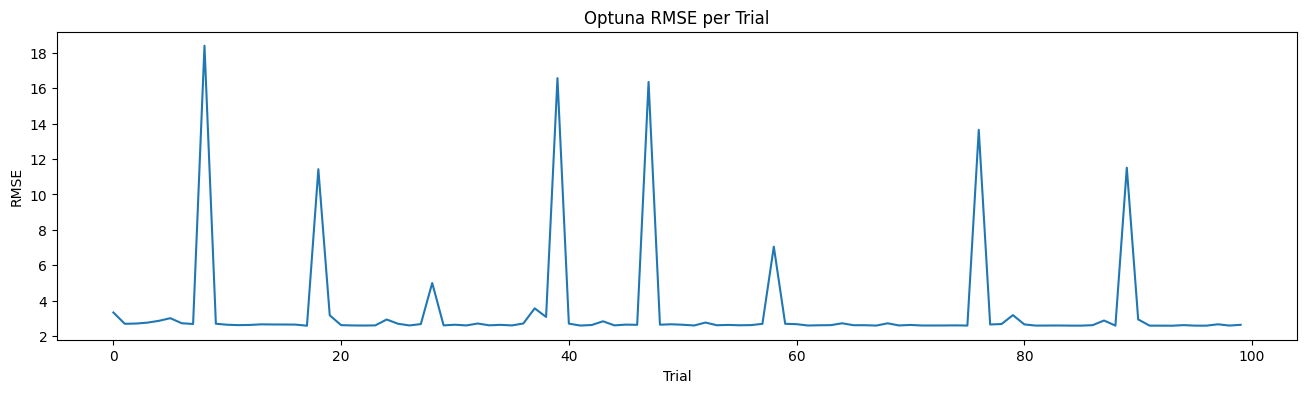

In [39]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [15]:
vis.plot_parallel_coordinate(temp_study)

In [16]:
vis.plot_param_importances(study=temp_study)

In [17]:
completed_trials = studies_per_target['temp_next_2'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_2']

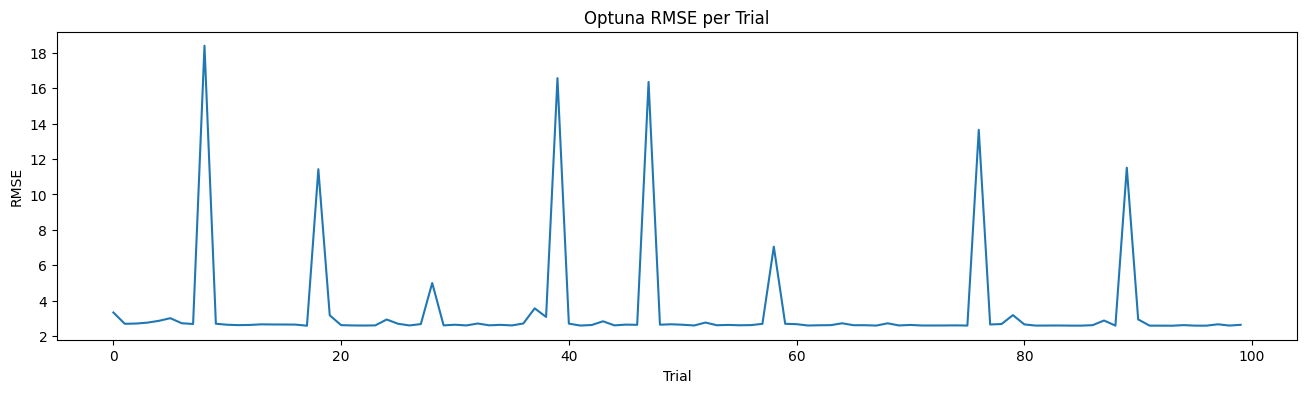

In [40]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [19]:
vis.plot_parallel_coordinate(temp_study)

In [20]:
vis.plot_param_importances(study=temp_study)

In [21]:
completed_trials = studies_per_target['temp_next_3'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_3']

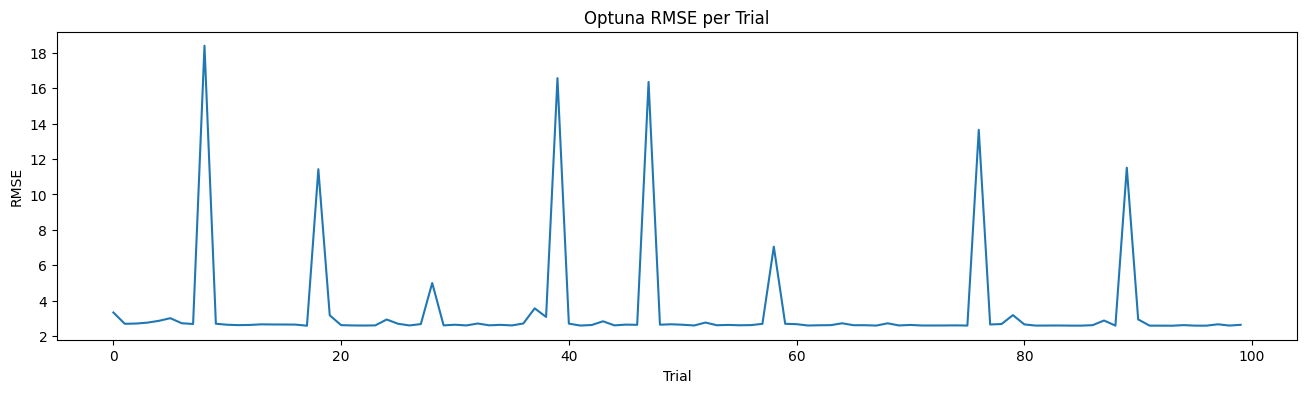

In [41]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [23]:
vis.plot_parallel_coordinate(temp_study)

In [24]:
vis.plot_param_importances(study=temp_study)

In [25]:
completed_trials = studies_per_target['temp_next_4'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_4']

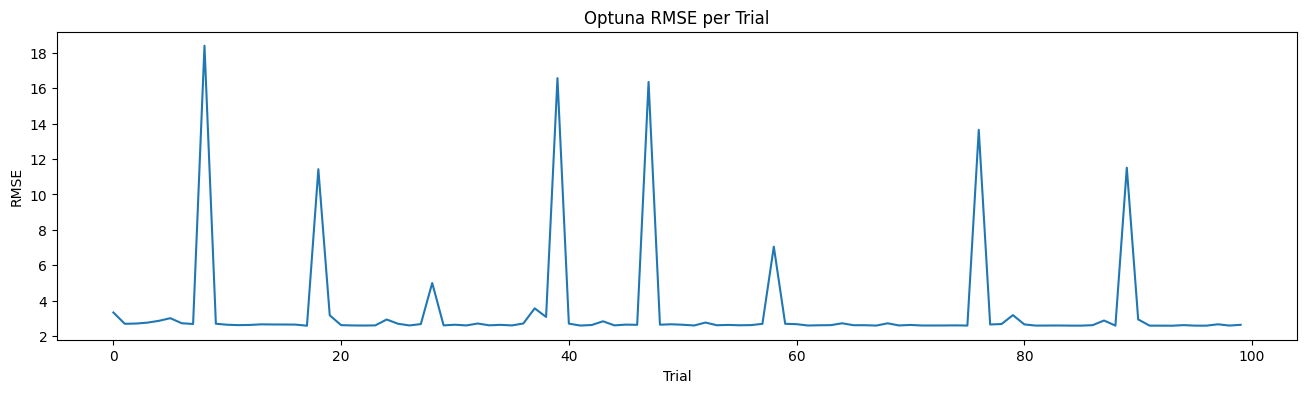

In [42]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [27]:
vis.plot_parallel_coordinate(temp_study)

In [28]:
vis.plot_param_importances(study=temp_study)

In [29]:
completed_trials = studies_per_target['temp_next_5'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_5']

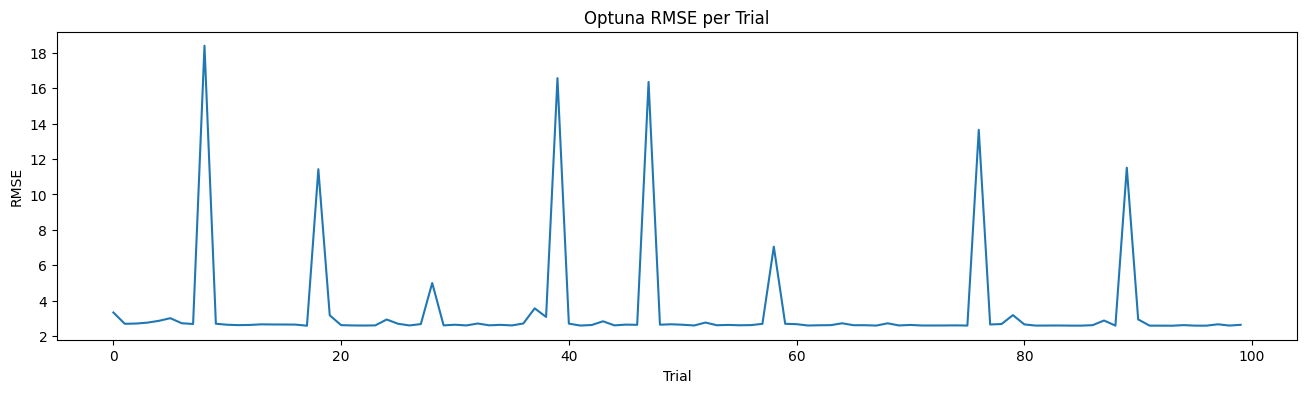

In [43]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [31]:
vis.plot_parallel_coordinate(temp_study)

In [32]:
vis.plot_param_importances(study=temp_study)

### **2.3. Training Final Model with Tuned Hyperparameters on Test Set**

In [ ]:
# === 4. Tạo MultiOutput wrapper cho LGBM ===
class CustomLGBMMultiOutputRegressor:
    def __init__(self, models_per_target):
        self.models_per_target = models_per_target
        self.target_names = list(models_per_target.keys())
   
    def predict(self, X):
        predictions = []
        for target_name, model_info in self.models_per_target.items():
            # Apply encoding
            X_encoded = model_info['encoding_pipeline'].transform(X)
            # Predict
            pred = model_info['model'].predict(X_encoded).reshape(-1, 1)
            predictions.append(pred)
        return np.hstack(predictions)
   
    def get_params(self, deep=True):
        return {"models_per_target": self.models_per_target}

# Tạo final model
final_lgbm_multi_model = CustomLGBMMultiOutputRegressor(best_lgbm_models_per_target)

# === 5. Đánh giá final model ===
y_pred_test_lgbm = final_lgbm_multi_model.predict(X_test)
y_pred_train_lgbm = final_lgbm_multi_model.predict(X_train)

final_test_metrics_lgbm = evaluate_multi_output(y_test, y_pred_test_lgbm)
final_train_metrics_lgbm = evaluate_multi_output(y_train, y_pred_train_lgbm)

print("LGBM Final Model - Test metrics (average):", final_test_metrics_lgbm["average"])
print("LGBM Final Model - Test metrics (perday):", final_test_metrics_lgbm["per_day"])
print()
print("LGBM Final Model - Train metrics (average):", final_train_metrics_lgbm["average"])
print("LGBM Final Model - Train metrics (perday):", final_train_metrics_lgbm["per_day"])

# === 6. Log final results ===
task_lgbm.upload_artifact("Best LGBM Parameters Per Target", best_lgbm_params_per_target)
task_lgbm.upload_artifact("LGBM Final Model - Test Metrics", final_test_metrics_lgbm)
task_lgbm.upload_artifact("LGBM Final Model - Train Metrics", final_train_metrics_lgbm)

# === 7. Lưu models ===
lgbm_models_path = r"models/LGBM_models_per_target.pkl"
joblib.dump({
    'models': best_lgbm_models_per_target,
    'params': best_lgbm_params_per_target,
    'final_model': final_lgbm_multi_model
}, lgbm_models_path)

print("=== LGBM TUNING COMPLETED ===")

LGBM Final Model - Test metrics (average): {'RMSE': np.float64(2.1898354467566215), 'MAE': np.float64(1.7299036560792758), 'R2': np.float64(0.8144632315120728)}
LGBM Final Model - Test metrics (perday): {'RMSE_day_1': np.float64(1.475606722249294), 'MAE_day_1': 1.1269363041201474, 'R2_day_1': 0.9181232851965655, 'RMSE_day_2': np.float64(2.1172344881468326), 'MAE_day_2': 1.6584585257715398, 'R2_day_2': 0.8315349949970183, 'RMSE_day_3': np.float64(2.3735721223665935), 'MAE_day_3': 1.8881661397991747, 'R2_day_3': 0.7885665882895302, 'RMSE_day_4': np.float64(2.466775961787568), 'MAE_day_4': 1.9774486308844743, 'R2_day_4': 0.771645697854786, 'RMSE_day_5': np.float64(2.5159879392328177), 'MAE_day_5': 1.9985086798210419, 'R2_day_5': 0.7624455912224644}

LGBM Final Model - Train metrics (average): {'RMSE': np.float64(1.776344531772574), 'MAE': np.float64(1.402763245751804), 'R2': np.float64(0.8762830619023066)}
LGBM Final Model - Train metrics (perday): {'RMSE_day_1': np.float64(1.224516939385

In [34]:
task_lgbm.close()

Skipping upload, could not find object file 'C:/Users/admin/AppData/Local/Temp/Best%20LGBM%20Parameters%20Per%20Target.2hqwg_a7.json'


## **3. Experiments & Results**

### **3.1. Experiment Summary Table**

| Experiment | RMSE | R² | MAE | Notes |
| :--- | :--- | :--- | :--- | :--- |
| Base Model | 2.399 | 0.756 | 1.874 | |
| Tuning #1 | 2.188 | 0.815 | 1.728 | 50 trials without pruner |
| Tuning #2 | 2.214 | 0.810 | 1.752 | 50 trials with pruner |
| Tuning #3 | 2.185 | 0.815 | 1.736 | 50 trials with pruner + fix objective |
| Tuning #4 | 2.206 | 0.812 | 1.752 | 100 trials with pruner |
| **Tuning #5 (Best model)** | **2.182** | **0.816** | **1.726** | 100 trials without pruner |
| Tuning #6 | 2.190 | 0.814 | 1.730 | 100 trials without pruner + fix objective |

### **3.2. Best model performance**

In [54]:
best_lgbm_model_path = r"models/LGBM_models_per_target_best.pkl" 
best_lgbm_model = joblib.load(best_lgbm_model_path)

y_pred_test_lgbm = best_lgbm_model['final_model'].predict(X_test)
y_pred_train_lgbm = best_lgbm_model['final_model'].predict(X_train)

final_test_metrics_lgbm = evaluate_multi_output(y_test, y_pred_test_lgbm)
final_train_metrics_lgbm = evaluate_multi_output(y_train, y_pred_train_lgbm)

print("LGBM Final Model - Test metrics (average):", final_test_metrics_lgbm["average"])
print("LGBM Final Model - Test metrics (perday):", final_test_metrics_lgbm["per_day"])
print()
print("LGBM Final Model - Train metrics (average):", final_train_metrics_lgbm["average"])
print("LGBM Final Model - Train metrics (perday):", final_train_metrics_lgbm["per_day"])

LGBM Final Model - Test metrics (average): {'RMSE': np.float64(2.181594722670966), 'MAE': np.float64(1.726147860762045), 'R2': np.float64(0.8158076907387617)}
LGBM Final Model - Test metrics (perday): {'RMSE_day_1': np.float64(1.4633131365561876), 'MAE_day_1': 1.1215557166588146, 'R2_day_1': 0.9194818660042289, 'RMSE_day_2': np.float64(2.1157042384955873), 'MAE_day_2': 1.662968637493637, 'R2_day_2': 0.8317784260910632, 'RMSE_day_3': np.float64(2.3712162868594286), 'MAE_day_3': 1.8952627749270803, 'R2_day_3': 0.7889860869379116, 'RMSE_day_4': np.float64(2.4661657676186213), 'MAE_day_4': 1.966226086955072, 'R2_day_4': 0.7717586576304613, 'RMSE_day_5': np.float64(2.491574183825004), 'MAE_day_5': 1.9847260877756208, 'R2_day_5': 0.7670334170301435}

LGBM Final Model - Train metrics (average): {'RMSE': np.float64(1.8374623369413343), 'MAE': np.float64(1.4580880501620208), 'R2': np.float64(0.8663884910500753)}
LGBM Final Model - Train metrics (perday): {'RMSE_day_1': np.float64(1.179131756933

### **3.3. Result Analysis** (generated by Gemini:>)

*   `The hyperparameter tuning process significantly improved performance compared to the baseline model. The best model (Tuning #5) achieved an average test RMSE of 2.182 (more precisely 2.1816), a substantial reduction from the baseline's RMSE of 2.399. This improvement is also reflected in the R² score, which increased from 0.756 (Baseline) to 0.816 (Tuning #5) (more precisely 0.8158). This indicates the tuned model explains a significantly larger portion of the data's variance.`

*   `Based on the Optuna plot_param_importances charts generated for each target (e.g., for temp_next_1, temp_next_3, temp_next_4, etc.), the most critical hyperparameters were consistently boosting_type and learning_rate. num_leaves and n_estimators also frequently showed a significant impact on performance. The feature encoding parameters, such as encoding_method_condition and the is_category flags, generally had a lower importance ranking, though they were still relevant.`

*   `An interesting finding from the experiment summary (Table 3.1) is that running 100 trials without a pruner (Tuning #5, RMSE 2.182) outperformed 100 trials with a pruner (Tuning #4, RMSE 2.206). This suggests the pruner may have prematurely terminated some promising trials. Furthermore, the optimization process confirmed the value of tuning models independently for each target, as it selected different optimal boosting_type values (gbdt and goss) for different forecast horizons (e.g., temp_next_1 vs temp_next_3).`

## **4. Conclusion** (again still generated by Gemini:>)

*   **Conclusion:** `Successfully developed a LightGBM model for temperature forecasting. The process involved comprehensive data preparation, feature engineering (creating lag and rolling features), and categorical encoding. A baseline model using default LGBM parameters established an initial test RMSE of 2.399. By employing Bayesian optimization with Optuna's TPESampler over 100 trials, we independently tuned models for each of the 5 forecast days. This tuning process led to the selection of "Tuning #5," which significantly improved performance, achieving a final average test RMSE of 2.182 and an R² of 0.816.`

## cái này không biết là gì

In [35]:
# Defaut Goss
tune_lgb = LGBMRegressor(
    boosting_type='goss',
    objective= 'regression', # loss function
    colsample_bytree=0.7688738230630878,
    learning_rate=0.015433744772417535,
    max_depth= 4,
    min_child_samples=50,
    min_split_gain=0.4084759794499262,
    n_estimators=417,
    num_leaves=128,
    reg_alpha=0.008,
    reg_lambda=0.008,
    # subsample=0.9098920662929666,
    # subsample_freq= 10,
    random_state=42,
    n_jobs=-1
)

model_grad = MultiOutputRegressor(estimator=tune_lgb, n_jobs=-1)

# 2️⃣ Time series cross-validation (chỉ trên tập train)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []  # lưu kết quả trung bình của mỗi fold

print("=== Time Series Cross-Validation ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Huấn luyện mô hình
    model_grad.fit(X_tr, y_tr)
    y_pred_val = model_grad.predict(X_val)
    
    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val)
    avg_val = metrics_val["average"]
    cv_scores.append(avg_val)
    
    print(f"\nFold {fold_idx} validation metrics:")
    print(avg_val)
    fold_idx += 1

# 3️⃣ Tổng hợp kết quả cross-validation
cv_df = pd.DataFrame(cv_scores)
print("\n=====> Cross-validation (Time Series) trung bình:")
print(cv_df.mean())

print("\n=====> Cross-validation (Time Series) độ lệch chuẩn (variance):")
print(cv_df.std())

# Sau khi bạn thấy mô hình ổn định qua các fold,
# bạn huấn luyện lại trên toàn bộ tập train rồi đánh giá 1 lần trên test (dữ liệu tương lai thật).

# 4️⃣ Huấn luyện lại toàn bộ tập train sau khi CV
model_grad.fit(X_train, y_train)


# 5️⃣ Đánh giá cuối cùng trên tập train
y_pred_train = model_grad.predict(X_train)
defGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("\n=====> Train metrics (trung bình):", defGrad_train_metrics["average"])
print("Train metrics (chi tiết từng ngày):", defGrad_train_metrics["per_day"])


# 5️⃣ Đánh giá cuối cùng trên tập test
y_pred_test = model_grad.predict(X_test)
defGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

print("\n=====> Test metrics (trung bình):", defGrad_test_metrics["average"])
print("Test metrics (chi tiết từng ngày):", defGrad_test_metrics["per_day"])

=== Time Series Cross-Validation ===

Fold 1 validation metrics:
{'RMSE': np.float64(2.4004768261188025), 'MAE': np.float64(1.8509984571024511), 'R2': np.float64(0.7526572012226735)}

Fold 2 validation metrics:
{'RMSE': np.float64(2.450950371664818), 'MAE': np.float64(1.9395699804376754), 'R2': np.float64(0.7219288127244973)}

Fold 3 validation metrics:
{'RMSE': np.float64(2.387888721486335), 'MAE': np.float64(1.905423151370807), 'R2': np.float64(0.7855829412528637)}

Fold 4 validation metrics:
{'RMSE': np.float64(2.1701923976988318), 'MAE': np.float64(1.7392628463756434), 'R2': np.float64(0.818871679696682)}

Fold 5 validation metrics:
{'RMSE': np.float64(2.0832605246118963), 'MAE': np.float64(1.624226757449179), 'R2': np.float64(0.8075616171188656)}

=====> Cross-validation (Time Series) trung bình:
RMSE    2.298554
MAE     1.811896
R2      0.777320
dtype: float64

=====> Cross-validation (Time Series) độ lệch chuẩn (variance):
RMSE    0.161572
MAE     0.129492
R2      0.039956
dtype